# **Model Development**

## **1. Import Libraries**

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors 

# Import Matlab Data
from scipy.io import loadmat

# Data Preparation
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler

# Support Vector Machine
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.decomposition import PCA 

# Accuracy Calculation
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

## **2. Import the Data**

##### **2.1 Load the .mat file (input) and .csv file (output)**

- EEG and ECG features are from 70-minute EEG and ECG data (70 minutes = 5 (pre-driving) + 60 (driving) + 5 (post-driving))
- ORD Labels are assigned on 60-minute driving phase

In [2]:
# Specify the Subject 
# subject = int(input('subject: '))
subject = 1 # use data from subject 1 for this project

# [INPUT: EEG & ECG data] load the .mat file

data = loadmat(f'dataset/EEG_ECG_Features_subject{subject}.mat')
ECG_features = data['ECG_features'] # the struct array of ECG features
EEG_features = data['EEG_features'] # the struct array of EEG features

# [OUTPUT: ORD] load the .xlsx file with separated sheets for each subject
ord_filepath = 'dataset/ORD_labels.xlsx' 

xl = pd.ExcelFile(ord_filepath)
sheet_name = xl.sheet_names[subject-1] 

ord_60min = pd.read_excel(ord_filepath, sheet_name=sheet_name)

In [3]:
ECG_field_names = ECG_features.dtype.names
EEG_field_names = EEG_features.dtype.names
print('Loaded Data')
print('ECG Features: ', ECG_field_names) # data stored in 'ECG_features'
print('EEG Features: ', EEG_field_names) # data stored in 'EEG_features'

Loaded Data
ECG Features:  ('Index', 'ECG', 'ECGTimestamps', 'RRI', 'RRITimestamps', 'VLF', 'LF', 'HF', 'LFHF', 'RPeakTimestamps', 'pLF', 'pHF')
EEG Features:  ('Epoch', 'TotalPower', 'AlphaPower', 'AlphaRelative', 'ThetaPower', 'ThetaRelative', 'BetaPower1', 'BetaPower2', 'RBR', 'BetaPower', 'BetaRelative', 'DeltaPower', 'DeltaRelative', 'AlphaBetaRatio', 'TA_BRatio')


##### **2.2 [ECG] Create dataframe of selected ECG features** (ECG_features_df)

- *ECG_features_df*: The dataframe of selected ECG features (*Index, VLF, LF, HF, LFHF, pLF, pHF*)

In [4]:
ECG_features_py = []

# Loop through each struct in the struct array
for i in range(ECG_features.shape[0]):  # Adjusted loop for Nx1 struct array
    struct = ECG_features[i, 0]
    scalar_dict = {
        'Index': struct['Index'][0, 0],
        'VLF': struct['VLF'][0, 0],
        'LF': struct['LF'][0, 0],
        'HF': struct['HF'][0, 0],
        'LFHF': struct['LFHF'][0, 0],
        'pLF': struct['pLF'][0, 0],
        'pHF': struct['pHF'][0, 0]
    }
    ECG_features_py.append(scalar_dict)

ECG_features_df = pd.DataFrame(ECG_features_py)

##### **2.3 [EEG] Create dataframe of selected EEG features** (EEG_features_df)


- *EEG_features_df_list*: List of 12 dataframes, containing selected EEG features from 12 EEG channels

In [5]:
EEG_features_df_list = []

numEEGchannels = EEG_features.shape[1]
numEEGepochs = EEG_features.shape[0]
EEG_featurelist = ['Epoch', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative', 'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio']

for channel in range(numEEGchannels):  # loop through all EEG channels
    channelfeatures = []
    for epoch in range(numEEGepochs):  # loop through all EEG Epochs
        epochfeatures = {field: EEG_features[epoch, channel][field][0,0] for field in EEG_featurelist}
        channelfeatures.append(epochfeatures)
    
    channelfeatures_df = pd.DataFrame(channelfeatures)
    EEG_features_df_list.append(channelfeatures_df)

- *EEG_features_df*: The dataframe of selected EEG features (*Epoch, DeltaRelative, ThetaRelative, AlphaRelative, BetaRelative, AlphaBetaRatio, TA_BRatio*)

In [6]:
EEG_channel = 1
EEG_features_df = EEG_features_df_list[0] # Features from Channel 1

##### **2.4 [ORD] Create dataframe of ORD labels for each epoch** (ORD_epoch)


**1) Converting *ord_60min* to *ord_epoch***
- ***ord_60min***: ORD labels for each minute
- ***ord_epoch***: ORD labels for each epoch (1-minute length with 50% overlap)

In [7]:
ord_60min.head()

,Minutes,Rater 1,Rater 2,Mean
0,1,1.0,1.0,1.0
1,2,1.0,1.0,1.0
2,3,1.0,1.0,1.0
3,4,1.0,2.0,1.5
4,5,1.0,2.0,1.5


In [8]:
ord_epoch = []

for i in range(len(ord_60min) - 1):
    ord_epoch.append(ord_60min.iloc[i, 3])
    
    # Calculate and append the mean of the current and next ORD values
    mean_ord = np.mean([ord_60min.iloc[i, 3], ord_60min.iloc[i + 1, 3]])
    ord_epoch.append(mean_ord)

# Append the last ORD value since it won't have a subsequent value to average with
ord_epoch.append(ord_60min.iloc[-1, 3])

# Convert the list to a DataFrame and set the column title as 'ord score'
ord_epoch = pd.DataFrame(ord_epoch, columns=['ORD score'])

ord_epoch

,ORD score
0,1.00
1,1.00
2,1.00
3,1.00
4,1.00
...,...
114,5.00
115,4.75
116,4.50
117,4.50



**2) Simplify ORD labels to 3 classes**


'ORD class' is assigned for each epoch based on this criteria
- *Alert*: ORD score <= 2 
- *Moderately Drowsy*: 2 < ORD score <= 3
- *Extremely Drowsy*: ORD score > 3

In [9]:
ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2 if x <= 3 else 3)))

# Mapping from 'ORD class' to 'class name'
class_name_mapping = {
    1: 'Alert',
    2: 'Moderately Drowsy',
    3: 'Extremely Drowsy'
}

# Add 'class name' column by mapping 'ORD class' to names
ord_epoch['class name'] = ord_epoch['ORD class'].map(class_name_mapping)

ord_epoch

,ORD score,ORD class,class name
0,1.00,1.0,Alert
1,1.00,1.0,Alert
2,1.00,1.0,Alert
3,1.00,1.0,Alert
4,1.00,1.0,Alert
...,...,...,...
114,5.00,3.0,Extremely Drowsy
115,4.75,3.0,Extremely Drowsy
116,4.50,3.0,Extremely Drowsy
117,4.50,3.0,Extremely Drowsy


In [10]:
# Number of epochs in each class
class_counts = ord_epoch['class name'].value_counts()
print(class_counts)

class name
Extremely Drowsy     44
Alert                37
Moderately Drowsy    35
Name: count, dtype: int64


##### **2.5 Create dataframe of EEG features, ECG features, ORD labels for each epoch** (combined_data)

sync data from each dataframe, including only epochs in the 60-minute driving phase

In [11]:
# EEG_features_df (df 139x7): row 10-128, column 1-6
# ECG_features_df (df 139x7): row 10-128, column 1-6
# ord_epoch (df 119x3): all row, column 1-2

# 1) Select the specified rows and columns from each DataFrame
EEG_features_selected = EEG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
ECG_features_selected = ECG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
Epoch_minute = pd.DataFrame({'Epoch_minute': np.linspace(1, 1 + 0.5 * (119 - 1), 119)})
ord_epoch_selected = ord_epoch.iloc[:, 1:3]  # Columns 1-2

# 2) Combine these features into a new DataFrame
# Concatenate EEG and ECG features along the columns
combined_data = pd.concat([Epoch_minute.reset_index(drop=True),
                               EEG_features_selected.reset_index(drop=True), 
                               ECG_features_selected.reset_index(drop=True),
                               ord_epoch_selected.reset_index(drop=True)], axis=1)
combined_data = combined_data.dropna()

# Now combined_data contains your inputs (EEG and ECG features) and outputs (ORD class and class name)
print(combined_data.shape)
combined_data

(116, 15)


,Epoch_minute,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,0.921231,0.022093,0.015880,0.036776,0.431814,1.032557,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383,1.0,Alert
1,1.5,0.912408,0.026312,0.016543,0.040918,0.404287,1.047324,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813,1.0,Alert
2,2.0,0.794278,0.069926,0.044227,0.086953,0.508633,1.312813,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790,1.0,Alert
3,2.5,0.640235,0.096260,0.065788,0.169988,0.387014,0.953293,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076,1.0,Alert
4,3.0,0.495832,0.094549,0.076334,0.252951,0.301772,0.675557,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502,1.0,Alert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,58.0,0.605963,0.126133,0.126624,0.143499,0.882400,1.761378,1.444820,0.572815,0.095526,5.996425,85.706986,14.293014,3.0,Extremely Drowsy
115,58.5,0.524608,0.166240,0.168573,0.148951,1.131732,2.247807,1.451736,0.526397,0.124005,4.244954,80.934055,19.065945,3.0,Extremely Drowsy
116,59.0,0.476771,0.165637,0.166374,0.185226,0.898221,1.792463,1.627882,0.378916,0.143747,2.635996,72.497217,27.502783,3.0,Extremely Drowsy
117,59.5,0.464370,0.158201,0.164425,0.200096,0.821734,1.612360,0.969084,0.887466,0.256468,3.460337,77.580167,22.419833,3.0,Extremely Drowsy


## **3. Define Functions**

In [12]:
def classwise_accuracy(model, X_test_scaled, y_test):
    # Predict the labels for the test set
    y_pred = model.predict(X_test_scaled)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate accuracy for each class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    # Define class names mapping
    class_names = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }
    
    # Print accuracy for each class
    for i, accuracy in enumerate(class_accuracies, start=1):
        class_name = class_names.get(i, f"Class {i}")
        print(f"Accuracy of {class_name}: {accuracy * 100:.4f}%")

    # Separator
    print("-" * 40)
    
    # Calculate and print F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro') # Aggregates the contributions of all classes to compute the average F1 score. Focuses on overall performance.
    weighted_f1 = f1_score(y_test, y_pred, average='weighted') # Computes the F1 score for each class, but uses the number of true instances for each class as weight.
    macro_f1 = f1_score(y_test, y_pred, average='macro') # Computes the F1 score separately for each class and then takes the average. Treats all classes equally.
    
    print(f"Micro-average F1: {micro_f1 * 100:.4f}%") 
    print(f"Weighted-average F1: {weighted_f1 * 100:.4f}%")    
    print(f"Macro-average F1: {macro_f1 * 100:.4f}%")

In [13]:
def result_summary(model, X, X_scaled, y):
    # Predict labels on the training data
    y_pred = model.predict(X_scaled)
    original_index = X.index.to_numpy()

    # Create DataFrame with columns
    result_summary = pd.DataFrame({
        "Original Index": original_index,
        "Original Label": y,  # Original labels
        "Predicted Label": y_pred,  # Predicted labels
        "True/False": y_pred == y  # True/False indicator (correctness)
    })

    result_summary = result_summary.sort_values(by="Original Index")
    return result_summary

## **4. [MODEL1] EEG-ECG SVM**

##### **Data Preparation**

In [14]:
# INPUT: Epoch_minute + EEG features + ECG features
X = combined_data.iloc[:, 0:13].copy()
print(X.shape)
X.head()

(116, 13)


,Epoch_minute,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio,VLF,LF,HF,LFHF,pLF,pHF
0,1.0,0.921231,0.022093,0.015880,0.036776,0.431814,1.032557,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383
1,1.5,0.912408,0.026312,0.016543,0.040918,0.404287,1.047324,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813
2,2.0,0.794278,0.069926,0.044227,0.086953,0.508633,1.312813,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790
3,2.5,0.640235,0.096260,0.065788,0.169988,0.387014,0.953293,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076
4,3.0,0.495832,0.094549,0.076334,0.252951,0.301772,0.675557,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502


In [15]:
# OUTPUT: ORD class
y = combined_data['ORD class'].copy()
print(y.shape)
y.head()

(116,)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: ORD class, dtype: float64

In [16]:
# Specify seed
seed = 8

In [17]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, train_size = 0.8)

# Data Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### **4.1 Preliminary SVM (Default parameters)**

In [18]:
# Prelim SVM

clf_svm_prelim = SVC(random_state=seed)
clf_svm_prelim.fit(X_train_scaled, y_train)

SVC(random_state=8)

* **Preliminary SVM: Training Accuracy**

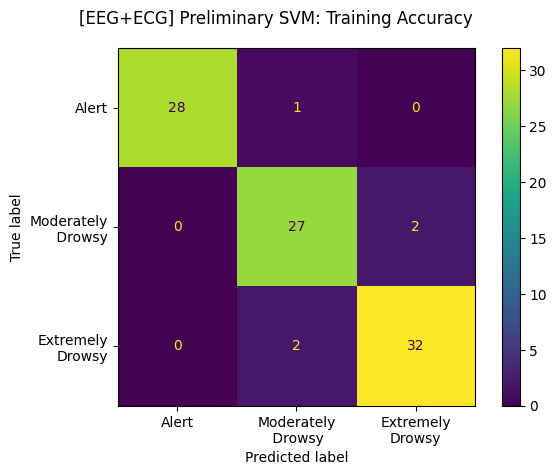

In [19]:
# Preliminary SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[EEG+ECG] Preliminary SVM: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [20]:
# Training Accuracy
classwise_accuracy(clf_svm_prelim, X_train_scaled, y_train)

Accuracy of Alert: 96.5517%
Accuracy of Moderately Drowsy: 93.1034%
Accuracy of Extremely Drowsy: 94.1176%
----------------------------------------
Micro-average F1: 94.5652%
Weighted-average F1: 94.6017%
Macro-average F1: 94.6296%


* **Preliminary SVM: Testing Accuracy**

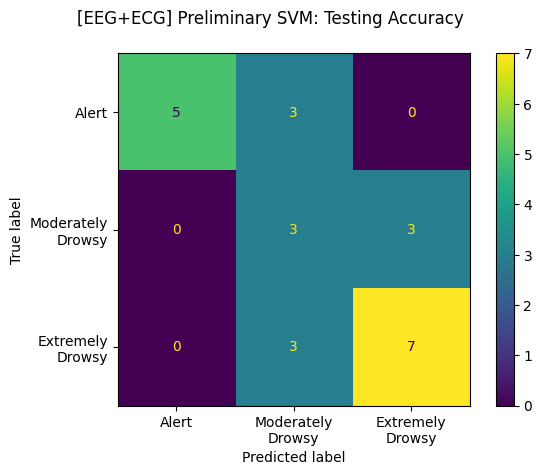

In [21]:
# Preliminary SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("[EEG+ECG] Preliminary SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [22]:
# Testing Accuracy
classwise_accuracy(clf_svm_prelim, X_test_scaled, y_test)

Accuracy of Alert: 62.5000%
Accuracy of Moderately Drowsy: 50.0000%
Accuracy of Extremely Drowsy: 70.0000%
----------------------------------------
Micro-average F1: 62.5000%
Weighted-average F1: 64.8077%
Macro-average F1: 62.3077%


In [23]:
# Result Summary: Preliminary SVM (training)
result_summary(clf_svm_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [24]:
# Result Summary: Preliminary SVM (testing)
result_summary(clf_svm_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,2.0,False
1,1,1.0,2.0,False
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,2.0,False
36,36,1.0,1.0,True
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **4.2 Optimized SVM (Optimal parameters)**

In [25]:
# Cross-Validation -> find parameters that maximize CV accuracy

param_grid = [
    {'C': [0.5, 1, 10, 100], # Regularization parameter must be > 0 #
     'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf', 'poly']},
]

optimal_params = GridSearchCV( 
    SVC(random_state=seed), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=1
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

best_cv_accuracy = optimal_params.best_score_
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

Fitting 5 folds for each of 56 candidates, totalling 280 fits
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8918


In [26]:
# Building, Evaluating, Drawing, Interpreting the Final SVM

clf_svm_cv = SVC(random_state=seed, C=10, gamma=0.01, kernel='rbf')
clf_svm_cv.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.01, random_state=8)

* **Optimized SVM: Training Accuracy**

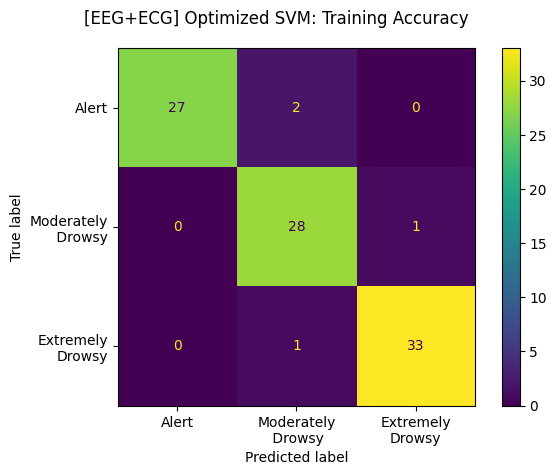

In [27]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[EEG+ECG] Optimized SVM: Training Accuracy")
plt.tight_layout()
plt.show()

In [28]:
# Training Accuracy
classwise_accuracy(clf_svm_cv, X_train_scaled, y_train)

Accuracy of Alert: 93.1034%
Accuracy of Moderately Drowsy: 96.5517%
Accuracy of Extremely Drowsy: 97.0588%
----------------------------------------
Micro-average F1: 95.6522%
Weighted-average F1: 95.6858%
Macro-average F1: 95.6069%


* **Optimized SVM: Testing Accuracy**

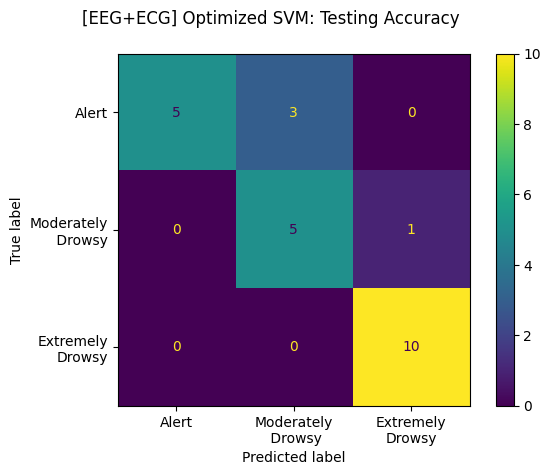

In [29]:
# Optimized SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[EEG+ECG] Optimized SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [30]:
# Testing Accuracy
classwise_accuracy(clf_svm_cv, X_test_scaled, y_test)

Accuracy of Alert: 62.5000%
Accuracy of Moderately Drowsy: 83.3333%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 83.3333%
Weighted-average F1: 83.1807%
Macro-average F1: 81.1966%


In [31]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_svm_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,2.0,False
33,33,1.0,2.0,False
36,36,1.0,2.0,False
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **4.3 PCA-SVM (Principal Components & Optimal parameters)**

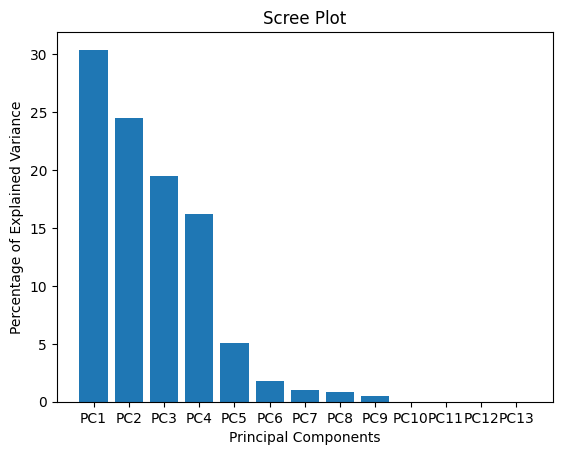

In [32]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
pca_transformer = pca.fit(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [33]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          )))

In [34]:
param_grid = [
    {'C': [0.5, 1, 10, 100, 1000], # Note: Values for C must be > 0
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVC(random_state=seed),
    # SVC(), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=0
)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


In [35]:
clf_svm_pca = SVC(random_state=seed, C=1000, gamma=0.01, kernel='rbf')
clf_svm_pca.fit(pca_train_scaled, y_train)

SVC(C=1000, gamma=0.01, random_state=8)

In [36]:
# Transform the test dataset with the PCA
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                         )))

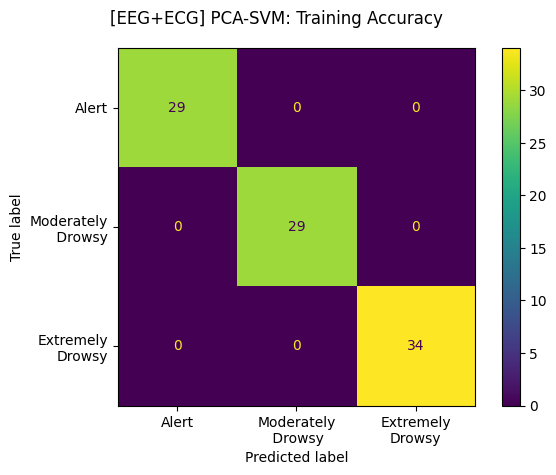

In [37]:
# PCA-SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[EEG+ECG] PCA-SVM: Training Accuracy")
plt.tight_layout()
plt.show()


In [38]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_svm_pca, pca_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


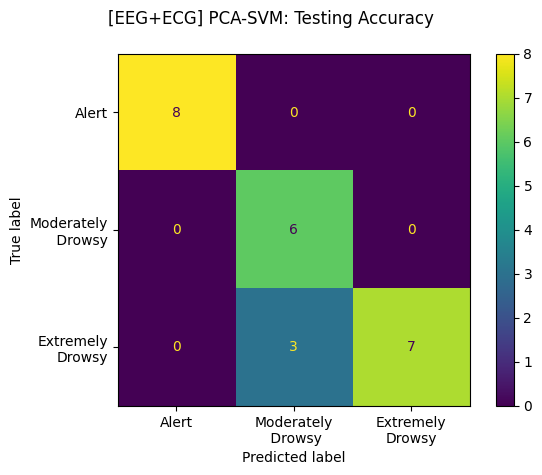

In [39]:
# PCA-SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[EEG+ECG] PCA-SVM: Testing Accuracy")
plt.tight_layout()
plt.show()


In [40]:
# PCA-SVM: Testing Accuracy
classwise_accuracy(clf_svm_pca, pca_test_scaled, y_test)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 70.0000%
----------------------------------------
Micro-average F1: 87.5000%
Weighted-average F1: 87.6471%
Macro-average F1: 87.4510%


In [41]:
# Result Summary: SVM-PCA (training)
result_summary(clf_svm_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [42]:
# Result Summary: SVM-PCA (testing)
result_summary(clf_svm_pca, X_test, pca_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,1.0,True
36,36,1.0,1.0,True
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


## **5. [MODEL2] EEG SVM**

##### **Data Preparation**

In [43]:
# INPUT: Epoch_minute + EEG features 
X = combined_data.iloc[:, 0:6].copy()
print(X.shape)
X.head()

(116, 6)


,Epoch_minute,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio
0,1.0,0.921231,0.022093,0.015880,0.036776,0.431814
1,1.5,0.912408,0.026312,0.016543,0.040918,0.404287
2,2.0,0.794278,0.069926,0.044227,0.086953,0.508633
3,2.5,0.640235,0.096260,0.065788,0.169988,0.387014
4,3.0,0.495832,0.094549,0.076334,0.252951,0.301772


In [44]:
# OUTPUT: ORD class
y = combined_data['ORD class'].copy()
print(y.shape)
y.head()

(116,)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: ORD class, dtype: float64

In [45]:
# Specify seed
seed = 8

In [46]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, train_size = 0.8)

# Data Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### **5.1 Preliminary SVM (Default parameters)**

In [47]:
# Prelim SVM

clf_svm_prelim = SVC(random_state=seed)
clf_svm_prelim.fit(X_train_scaled, y_train)

SVC(random_state=8)

* **Preliminary SVM: Training Accuracy**

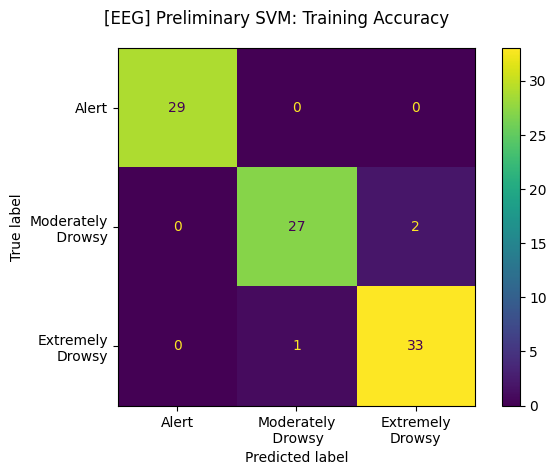

In [48]:
# Preliminary SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[EEG] Preliminary SVM: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [49]:
# Training Accuracy
classwise_accuracy(clf_svm_prelim, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 93.1034%
Accuracy of Extremely Drowsy: 97.0588%
----------------------------------------
Micro-average F1: 96.7391%
Weighted-average F1: 96.7342%
Macro-average F1: 96.7963%


* **Preliminary SVM: Testing Accuracy**

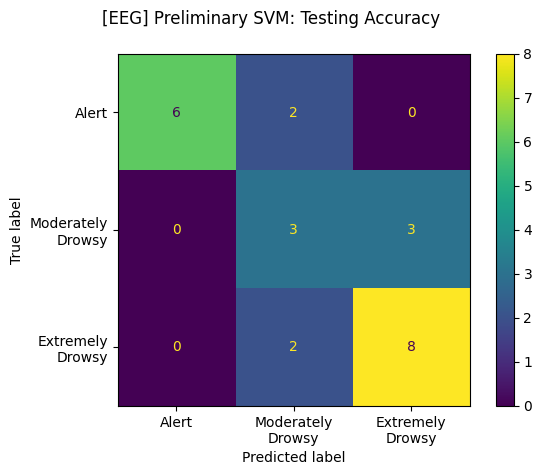

In [50]:
# Preliminary SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("[EEG] Preliminary SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [51]:
# Testing Accuracy
classwise_accuracy(clf_svm_prelim, X_test_scaled, y_test)

Accuracy of Alert: 75.0000%
Accuracy of Moderately Drowsy: 50.0000%
Accuracy of Extremely Drowsy: 80.0000%
----------------------------------------
Micro-average F1: 70.8333%
Weighted-average F1: 71.8559%
Macro-average F1: 69.3529%


In [52]:
# Result Summary: Preliminary SVM (training)
result_summary(clf_svm_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [53]:
# Result Summary: Preliminary SVM (testing)
result_summary(clf_svm_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,2.0,False
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,2.0,False
36,36,1.0,1.0,True
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **5.2 Optimized SVM (Optimal parameters)**

In [54]:
# Cross-Validation -> find parameters that maximize CV accuracy

param_grid = [
    {'C': [0.5, 1, 10, 100], # Regularization parameter must be > 0 #
     'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf', 'poly']},
]

optimal_params = GridSearchCV( 
    SVC(random_state=seed), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=1
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

best_cv_accuracy = optimal_params.best_score_
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

Fitting 5 folds for each of 56 candidates, totalling 280 fits
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.9351


In [55]:
# Building, Evaluating, Drawing, Interpreting the Final SVM

clf_svm_cv = SVC(random_state=seed, C=10, gamma=0.01, kernel='rbf')
clf_svm_cv.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.01, random_state=8)

* **Optimized SVM: Training Accuracy**

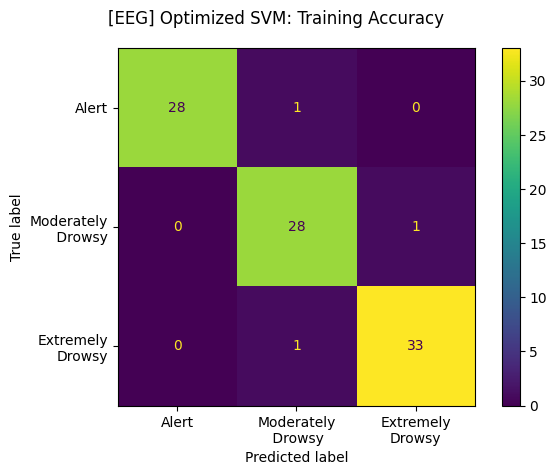

In [56]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[EEG] Optimized SVM: Training Accuracy")
plt.tight_layout()
plt.show()

In [57]:
# Training Accuracy
classwise_accuracy(clf_svm_cv, X_train_scaled, y_train)

Accuracy of Alert: 96.5517%
Accuracy of Moderately Drowsy: 96.5517%
Accuracy of Extremely Drowsy: 97.0588%
----------------------------------------
Micro-average F1: 96.7391%
Weighted-average F1: 96.7572%
Macro-average F1: 96.7399%


* **Optimized SVM: Testing Accuracy**

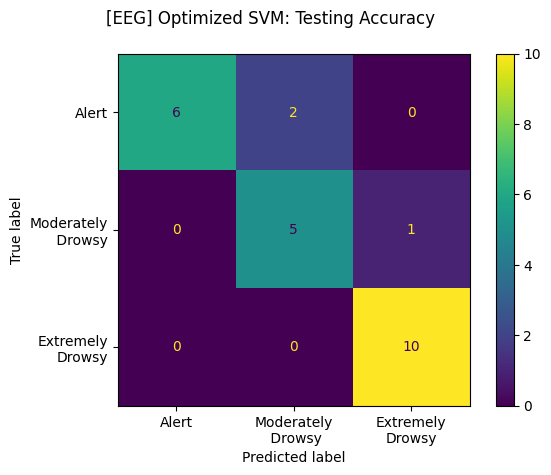

In [58]:
# Optimized SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[EEG] Optimized SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [59]:
# Testing Accuracy
classwise_accuracy(clf_svm_cv, X_test_scaled, y_test)

Accuracy of Alert: 75.0000%
Accuracy of Moderately Drowsy: 83.3333%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 87.5000%
Weighted-average F1: 87.4847%
Macro-average F1: 85.9585%


In [60]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_svm_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,2.0,False
36,36,1.0,2.0,False
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **5.3 PCA-SVM (Principal Components & Optimal parameters)**

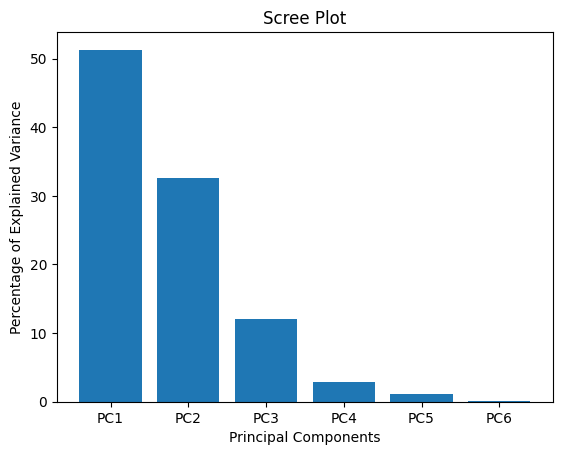

In [61]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
pca_transformer = pca.fit(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [62]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          )))

In [63]:
param_grid = [
    {'C': [0.5, 1, 10, 100, 1000], # Note: Values for C must be > 0
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVC(random_state=seed), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=0
)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


In [64]:
clf_svm_pca = SVC(random_state=seed, C=1000, gamma=0.01, kernel='rbf')
clf_svm_pca.fit(pca_train_scaled, y_train)

SVC(C=1000, gamma=0.01, random_state=8)

In [65]:
# Transform the test dataset with the PCA
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         )))

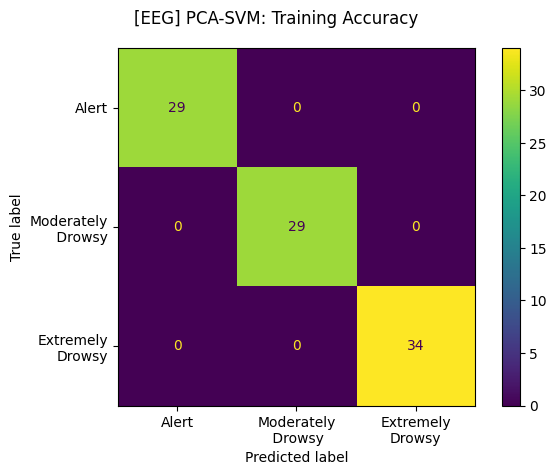

In [66]:
# PCA-SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[EEG] PCA-SVM: Training Accuracy")
plt.tight_layout()
plt.show()


In [67]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_svm_pca, pca_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


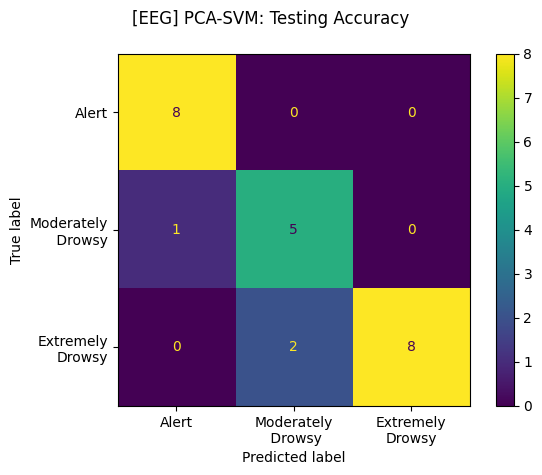

In [68]:
# PCA-SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[EEG] PCA-SVM: Testing Accuracy")
plt.tight_layout()
plt.show()


In [69]:
# PCA-SVM: Testing Accuracy
classwise_accuracy(clf_svm_pca, pca_test_scaled, y_test)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 83.3333%
Accuracy of Extremely Drowsy: 80.0000%
----------------------------------------
Micro-average F1: 87.5000%
Weighted-average F1: 87.6404%
Macro-average F1: 86.6432%


In [70]:
# Result Summary: SVM-PCA (training)
result_summary(clf_svm_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [71]:
# Result Summary: SVM-PCA (testing)
result_summary(clf_svm_pca, X_test, pca_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,1.0,True
36,36,1.0,1.0,True
38,38,1.0,1.0,True
43,43,2.0,1.0,False
60,60,2.0,2.0,True


## **6. [MODEL3] ECG SVM**

##### **Data Preparation**

In [72]:
# INPUT: Epoch_minute + ECG features 
X = combined_data.iloc[:, [0] + list(range(7, 13))].copy()
print(X.shape)
X.head()

(116, 7)


,Epoch_minute,VLF,LF,HF,LFHF,pLF,pHF
0,1.0,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383
1,1.5,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813
2,2.0,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790
3,2.5,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076
4,3.0,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502


In [73]:
# OUTPUT: ORD class
y = combined_data['ORD class'].copy()
print(y.shape)
y.head()

(116,)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: ORD class, dtype: float64

In [74]:
# Specify seed
seed = 8

In [75]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, train_size = 0.8)

# Data Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### **6.1 Preliminary SVM (Default parameters)**

In [76]:
# Prelim SVM

clf_svm_prelim = SVC(random_state=seed)
clf_svm_prelim.fit(X_train_scaled, y_train)

SVC(random_state=8)

* **Preliminary SVM: Training Accuracy**

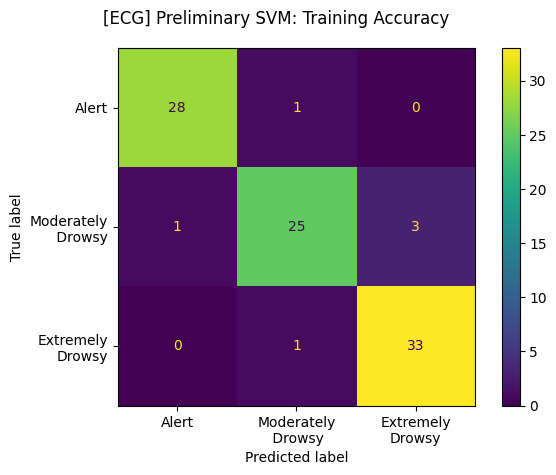

In [77]:
# Preliminary SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[ECG] Preliminary SVM: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [78]:
# Training Accuracy
classwise_accuracy(clf_svm_prelim, X_train_scaled, y_train)

Accuracy of Alert: 96.5517%
Accuracy of Moderately Drowsy: 86.2069%
Accuracy of Extremely Drowsy: 97.0588%
----------------------------------------
Micro-average F1: 93.4783%
Weighted-average F1: 93.4239%
Macro-average F1: 93.3744%


* **Preliminary SVM: Testing Accuracy**

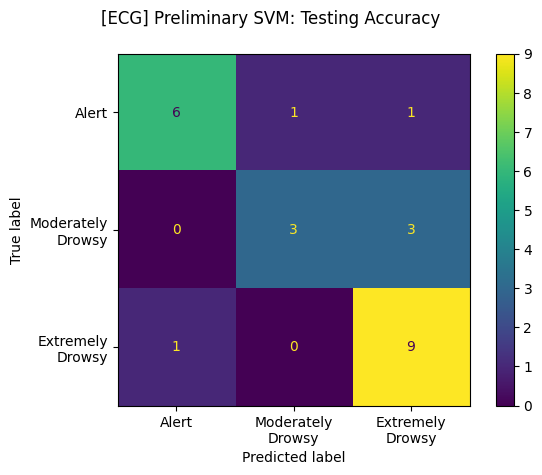

In [79]:
# Preliminary SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("[ECG] Preliminary SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [80]:
# Testing Accuracy
classwise_accuracy(clf_svm_prelim, X_test_scaled, y_test)

Accuracy of Alert: 75.0000%
Accuracy of Moderately Drowsy: 50.0000%
Accuracy of Extremely Drowsy: 90.0000%
----------------------------------------
Micro-average F1: 75.0000%
Weighted-average F1: 74.2754%
Macro-average F1: 72.7536%


In [81]:
# Result Summary: Preliminary SVM (training)
result_summary(clf_svm_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [82]:
# Result Summary: Preliminary SVM (testing)
result_summary(clf_svm_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,2.0,False
36,36,1.0,1.0,True
38,38,1.0,3.0,False
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **6.2 Optimized SVM (Optimal parameters)**

In [83]:
# Cross-Validation -> find parameters that maximize CV accuracy

param_grid = [
    {'C': [0.5, 1, 10, 100], # Regularization parameter must be > 0 #
     'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf', 'poly']},
]

optimal_params = GridSearchCV( 
    SVC(random_state=seed), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=1
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

best_cv_accuracy = optimal_params.best_score_
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

Fitting 5 folds for each of 56 candidates, totalling 280 fits
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.9240


In [84]:
# Building, Evaluating, Drawing, Interpreting the Final SVM

clf_svm_cv = SVC(random_state=seed, C=10, gamma=0.01, kernel='rbf')
clf_svm_cv.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.01, random_state=8)

* **Optimized SVM: Training Accuracy**

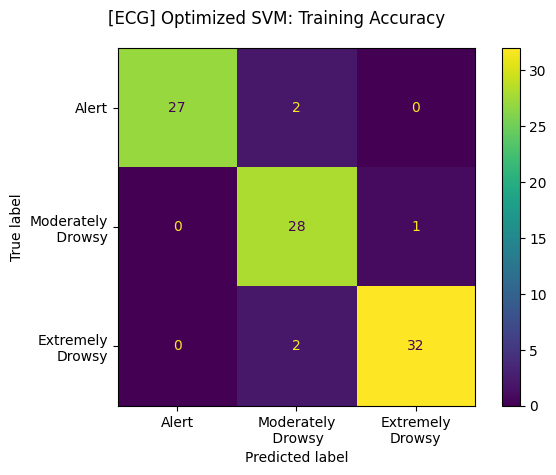

In [85]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[ECG] Optimized SVM: Training Accuracy")
plt.tight_layout()
plt.show()

In [86]:
# Training Accuracy
classwise_accuracy(clf_svm_cv, X_train_scaled, y_train)

Accuracy of Alert: 93.1034%
Accuracy of Moderately Drowsy: 96.5517%
Accuracy of Extremely Drowsy: 94.1176%
----------------------------------------
Micro-average F1: 94.5652%
Weighted-average F1: 94.6357%
Macro-average F1: 94.5847%


* **Optimized SVM: Testing Accuracy**

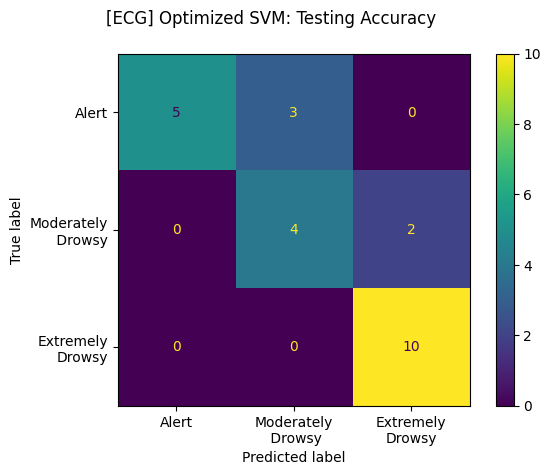

In [87]:
# Optimized SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[ECG] Optimized SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [88]:
# Testing Accuracy
classwise_accuracy(clf_svm_cv, X_test_scaled, y_test)

Accuracy of Alert: 62.5000%
Accuracy of Moderately Drowsy: 66.6667%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 79.1667%
Weighted-average F1: 78.9044%
Macro-average F1: 76.4569%


In [89]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_svm_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,2.0,False
33,33,1.0,2.0,False
36,36,1.0,2.0,False
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **6.3 PCA-SVM (Principal Components & Optimal parameters)**

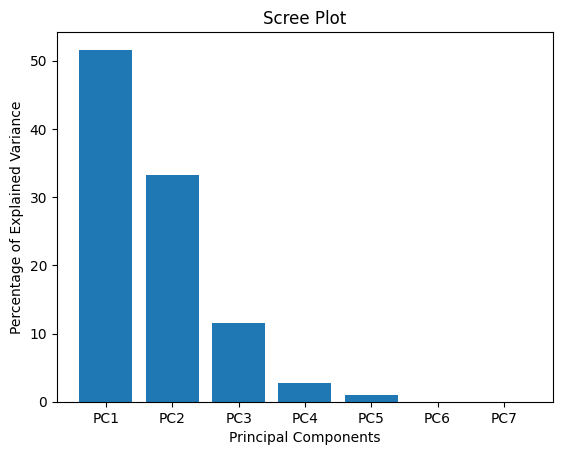

In [90]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
pca_transformer = pca.fit(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [91]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          )))

In [92]:
param_grid = [
    {'C': [0.5, 1, 10, 100, 1000], # Note: Values for C must be > 0
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVC(random_state=seed), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=0
)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [93]:
clf_svm_pca = SVC(random_state=seed, C=10, gamma=0.01, kernel='rbf')
clf_svm_pca.fit(pca_train_scaled, y_train)

SVC(C=10, gamma=0.01, random_state=8)

In [94]:
# Transform the test dataset with the PCA
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords,    
                                         )))

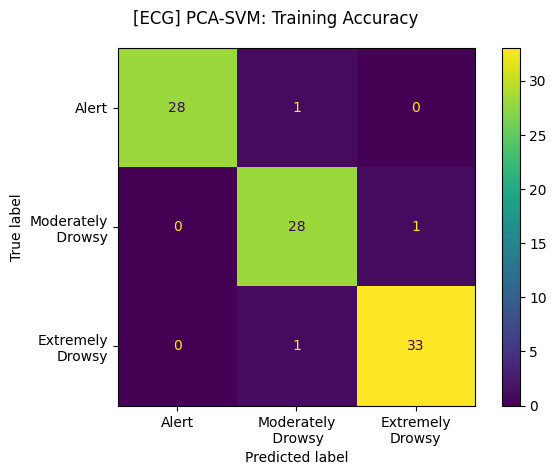

In [95]:
# PCA-SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[ECG] PCA-SVM: Training Accuracy")
plt.tight_layout()
plt.show()


In [96]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_svm_pca, pca_train_scaled, y_train)

Accuracy of Alert: 96.5517%
Accuracy of Moderately Drowsy: 96.5517%
Accuracy of Extremely Drowsy: 97.0588%
----------------------------------------
Micro-average F1: 96.7391%
Weighted-average F1: 96.7572%
Macro-average F1: 96.7399%


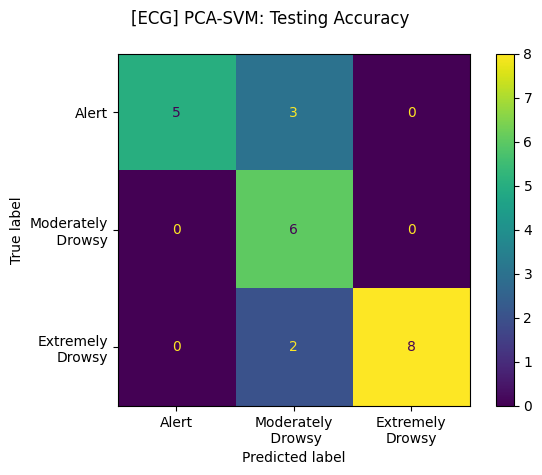

In [97]:
# PCA-SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("[ECG] PCA-SVM: Testing Accuracy")
plt.tight_layout()
plt.show()


In [98]:
# PCA-SVM: Testing Accuracy
classwise_accuracy(clf_svm_pca, pca_test_scaled, y_test)

Accuracy of Alert: 62.5000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 80.0000%
----------------------------------------
Micro-average F1: 79.1667%
Weighted-average F1: 80.3251%
Macro-average F1: 78.8001%


In [99]:
# Result Summary: SVM-PCA (training)
result_summary(clf_svm_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [100]:
# Result Summary: SVM-PCA (testing)
result_summary(clf_svm_pca, X_test, pca_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,2.0,False
33,33,1.0,2.0,False
36,36,1.0,2.0,False
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True
